In [28]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer

In [29]:
df=pd.read_excel('dataset_filledsupplier_currency_orderday.xlsx')

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24621 entries, 0 to 24620
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   청구서번호        24621 non-null  object 
 1   No.          24621 non-null  int64  
 2   Subject      24599 non-null  object 
 3   Machinery    24621 non-null  object 
 4   Assembly     24621 non-null  object 
 5   청구품목         24621 non-null  object 
 6   Unnamed: 6   0 non-null      float64
 7   Part No.1    24602 non-null  object 
 8   Part No.2    3592 non-null   object 
 9   청구량          24517 non-null  float64
 10  견적           24171 non-null  object 
 11  견적수량         24517 non-null  float64
 12  견적화폐         24621 non-null  object 
 13  견적단가         24621 non-null  float64
 14  발주번호         24621 non-null  object 
 15  발주처          24621 non-null  object 
 16  발주           24621 non-null  object 
 17  발주수량         24621 non-null  int64  
 18  발주금액         24621 non-null  float64
 19  D/T 

In [31]:
print(len(df['발주처'].unique()))

81


## 클리닝

In [32]:
missing_conditions = df[
    df['발주'].notnull() &  # 발주 일자는 비어있지 않음
    df['미입고 기간'].isnull() &  # 미입고 기간은 비어있음
    df['창고입고'].isnull() & # 창고 입고도 비어있음
    df['선박입고'].isnull()  # 선박 입고도 비어있음

]

print(f"발주 일자는 있지만 미입고 기간, 창고 입고, 선박 입고도 없는 경우: {len(missing_conditions)}개")
df = df.drop(missing_conditions.index)

print(f"삭제된 행의 개수: {len(missing_conditions)}개")
print(f"남은 데이터프레임의 크기: {df.shape}")

발주 일자는 있지만 미입고 기간, 창고 입고, 선박 입고도 없는 경우: 1699개
삭제된 행의 개수: 1699개
남은 데이터프레임의 크기: (22922, 32)


In [33]:
#미입고기간으로 처리.
missing_both = df[df['창고입고'].isnull() & df['미입고 기간'].notnull()]

print(f"창고 입고일은 없고 미입고 기간은 명시되어 있어 미입고 기간으로 분류해야 할 경우 : {len(missing_both)}개")

창고 입고일은 없고 미입고 기간은 명시되어 있어 미입고 기간으로 분류해야 할 경우 : 1620개


In [34]:
df = df[df['미입고 기간'].isnull()]

df['발주'] = pd.to_datetime(df['발주'], errors='coerce')
df['창고입고'] = pd.to_datetime(df['창고입고'], errors='coerce')

# 리드타임 계산
df['리드타임'] = (df['창고입고'] - df['발주']).dt.days

# 리드타임이 0인 경우 1로 변경
df['리드타임'] = df['리드타임'].apply(lambda x: 1 if x == 0 else x)

# 리드타임이 1일 미만이거나 200일을 초과한 경우 제거
df = df[(df['리드타임'] > 1 ) & (df['리드타임'] <=200)]

# 창고입고가 결측값인 행 제거
df = df.dropna(subset=['창고입고'])

print(df.shape)

(19333, 33)


In [35]:
machinery_avg_leadtime = df.groupby('Machinery')['리드타임'].mean().reset_index()

# 원본 데이터프레임에 병합하여 'Machinery'별 평균 리드타임 추가
df = df.merge(machinery_avg_leadtime, on='Machinery', how='left', suffixes=('', '_avg'))

In [36]:
df.head()

,청구서번호,No.,Subject,Machinery,Assembly,청구품목,Unnamed: 6,Part No.1,Part No.2,청구량,...,입고창고,창고출고,창고출고수량,출고선박,출고운반선,선박입고,선박입고수량,완료 여부,리드타임,리드타임_avg
0,COK-BS-DSP-1901004,1,COK-F-DECK-190104-01,CARGO BOOM VANG BLOCK (STBD 하),BLOCK,"MCKISSICK CONSTRUCTION BLOCKS (WIRE SIZE : 5/8"")",NaN,C15S10BS,2103170,2.0,...,BW,2019-05-20,2,COK,ONENESS,2019-06-09,2,완료,112,101.500000
1,COK-BS-DSP-1901004,2,COK-F-DECK-190104-01,SPANISH BOOM VANG BLOCK (PORT 상),BLOCK,"MCKISSICK CONSTRUCTION BLOCKS (WIRE SIZE : 5/8"")",NaN,C15D10BS,2103180,1.0,...,BW,2019-05-20,1,COK,ONENESS편 탁송,2019-06-09,1,완료,97,51.500000
2,COK-BS-DSP-1901004,3,COK-F-DECK-190104-01,PURSE BLOCK,TOW BLOCK,WESTEC 20TON TOW BLOCK,NaN,WESTEC 20TON TOW BLOCK,NaN,1.0,...,BW,2019-05-20,1,COK,ONENESS,2019-06-09,1,완료,112,100.000000
3,COK-BS-DSP-1906004,1,"COK-D-DECK-190527-02, NET 및 SAMSON ROPE",NET,H-EX,"H-EX #30 * 4 1/4"", 100MD * 120FMS",NaN,"HEX#30X4 1/4""X100MDX120FMS",NaN,2.0,...,BS,2019-06-15,2,COK,OCEANUS,2019-07-09,2,완료,12,16.627119
4,COK-BS-DSP-1906004,2,"COK-D-DECK-190527-02, NET 및 SAMSON ROPE",NET,NYLON,"NYLON #54 * 4 1/4"", 100MD * 50FMS",NaN,"NYLON#54X4-1/4""X100MDX50FMS",NaN,1.0,...,BS,2019-06-15,1,COK,OCEANUS,2019-07-09,1,완료,12,16.627119


In [37]:
print(df['리드타임'].describe())


count    19333.000000
mean        69.477784
std         51.866529
min          2.000000
25%         20.000000
50%         61.000000
75%        107.000000
max        200.000000
Name: 리드타임, dtype: float64


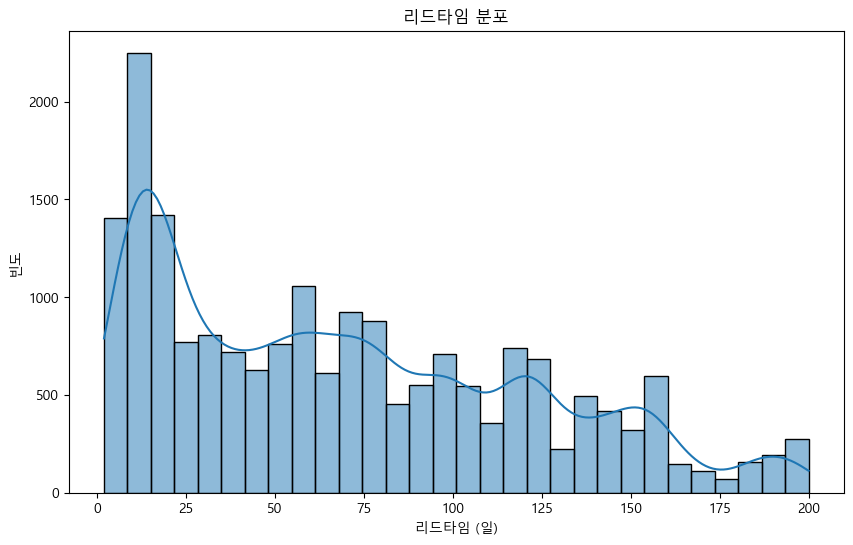

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family']='Malgun Gothic'

plt.figure(figsize=(10, 6))
sns.histplot(df['리드타임'], bins=30, kde=True)
plt.title('리드타임 분포')
plt.xlabel('리드타임 (일)')
plt.ylabel('빈도')
plt.show()

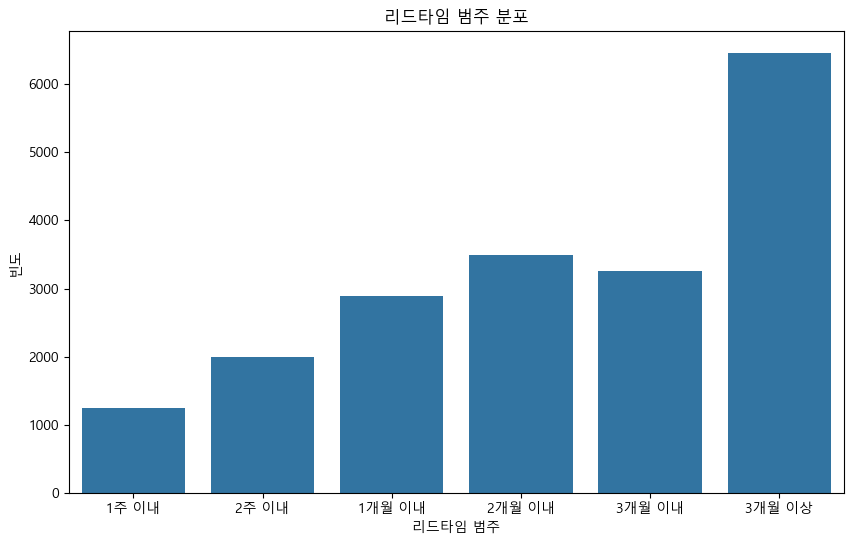

In [12]:
df['리드타임_범주'] = pd.cut(df['리드타임'], bins=[0, 7, 14, 30, 60, 90, df['리드타임'].max()], labels=['1주 이내', '2주 이내', '1개월 이내', '2개월 이내', '3개월 이내', '3개월 이상'])
plt.rcParams['font.family']='Malgun Gothic'
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='리드타임_범주')
plt.title('리드타임 범주 분포')
plt.xlabel('리드타임 범주')
plt.ylabel('빈도')
plt.show()

### 리드타임 예측 (회귀)
1. 텍스트 칼럼 결합 및 BERT 임베딩
2. ( 수치형 데이터(견적단가 및 발주량) Scaling )
3. 범주형 데이터(견적화폐) onehotEncoding
4. 모델의 입력, 2.3데이터 결합 => 리드타임 예측

## 전처리

> 각 텍스트 필드 개별적으로 rf idf 변환하고 결합

In [45]:
import re

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'[^\w\s\*/\-\+.,#&]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\b(사용금지|사)\b', '', text, flags=re.IGNORECASE)
    text = text.strip()
    return text

def clean_supplier_name(name):
    name = name.lower()
    name = re.sub(r'coporation|coropration|coproration|corporration', 'corporation', name)
    name = re.sub(r'\(사용금지\)', '', name)
    name = re.sub(r'u\.s\.a', '_usa', name)
    name = re.sub(r'\.', '', name)
    suffixes = r'(corporation|corp|company|co|incorporated|inc|limited|ltd|상사|공사|엔지니어링|주식회사|주|gmbh|pte ltd|llc)'
    name = re.sub(suffixes, '', name, flags=re.IGNORECASE)
    name = re.sub(r'[^\w\s-]', '', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name

In [46]:
text_columns = ['Machinery', 'Assembly', '청구품목']

for col in text_columns:
    df[col] = df[col].astype(str)
df['cleaned_machinery'] = df['Machinery'].apply(preprocess_text)
df['cleaned_assembly'] = df['Assembly'].apply(preprocess_text)
df['cleaned_item'] = df['청구품목'].apply(preprocess_text)


In [47]:
from gensim.models import FastText
import numpy as np

# 데이터 전처리 후 토큰화 (문장을 단어 리스트로 변환)
machinery_sentences = [text.split() for text in df['cleaned_machinery']]
assembly_sentences = [text.split() for text in df['cleaned_assembly']]
item_sentences = [text.split() for text in df['cleaned_item']]

# 각각의 FastText 모델 학습
fasttext_machinery = FastText(sentences=machinery_sentences, vector_size=100, window=5, min_count=1, workers=4)
fasttext_assembly = FastText(sentences=assembly_sentences, vector_size=100, window=5, min_count=1, workers=4)
fasttext_item = FastText(sentences=item_sentences, vector_size=100, window=5, min_count=1, workers=4)

# 각 텍스트에 대한 벡터 평균값 계산 (문장 단위로 벡터를 평균화하여 문장 벡터 생성)
def sentence_vector(sentence, model):
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# 각 컬럼별로 벡터화
machinery_vectors = np.array([sentence_vector(sentence, fasttext_machinery) for sentence in machinery_sentences])
assembly_vectors = np.array([sentence_vector(sentence, fasttext_assembly) for sentence in assembly_sentences])
item_vectors = np.array([sentence_vector(sentence, fasttext_item) for sentence in item_sentences])

# 결과 확인
print(f"FastText Machinery Shape: {machinery_vectors.shape}")
print(f"FastText Assembly Shape: {assembly_vectors.shape}")
print(f"FastText Item Shape: {item_vectors.shape}")

FastText Machinery Shape: (19333, 100)
FastText Assembly Shape: (19333, 100)
FastText Item Shape: (19333, 100)


In [42]:
#!conda install conda-forge::category_encoders -y

In [48]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
import numpy as np
from scipy.sparse import hstack, csr_matrix
import category_encoders as ce

# 환율 설정
exchange_rate = {
    'KRW': 1/1300, 
    'USD': 1,      
    'EUR': 1.1,     
    'JPY': 1/110    
}

# 1. 수치형 데이터 처리 (로그 변환 및 NaN 처리)
df['converted_unit_price'] = df.apply(lambda x: x['견적단가'] * exchange_rate[x['견적화폐']], axis=1)
df['converted_price'] = df['converted_unit_price'] * df['발주수량']

# 로그 변환 전에 0 이하의 값 제거
df = df[df['converted_price'] > 0]

# 로그 변환 후 NaN 값 제거
df['log_converted_price'] = np.log1p(df['converted_price'])

# 수치형 데이터에 대해 NaN 제거
df = df.dropna(subset=['log_converted_price', '발주수량'])




C:\Users\User\AppData\Local\Temp\ipykernel_11364\3444543933.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['log_converted_price'] = np.log1p(df['converted_price'])


In [62]:
from sklearn.preprocessing import OneHotEncoder

# 2. 발주처 전처리 및 인코딩
df['cleaned_supplier'] = df['발주처'].apply(clean_supplier_name)

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False)
supplier_encoded = ohe.fit_transform(df[['cleaned_supplier']])



In [64]:
# 5. One-Hot Encoding: 견적화폐와 발주처
currency_ohe = OneHotEncoder(sparse_output=False) 
currency_encoded = currency_ohe.fit_transform(df[['견적화폐']])

In [65]:
from sklearn.preprocessing import MinMaxScaler

# 3. 수치형 데이터 스케일링
scaler = StandardScaler()
log_price_scaled = scaler.fit_transform(df[['log_converted_price']])
leadtime_avg_scaled = scaler.fit_transform(df[['리드타임_avg']])

#발주수량은 스케일러 안함
q_scaler=MinMaxScaler ()
quantity_scaled = q_scaler.fit_transform(df[['발주수량']])



### 데이터 분할

> 로그 변환 및 tf-idf 벡터화 시 nan 값 생길 수 있으므로 처리에 주의요함

In [66]:

# 5. 수치형 데이터 결합 
# 5. 수치형 데이터 결합 
X_combined_numeric = np.hstack([
    log_price_scaled, 
    leadtime_avg_scaled,
    quantity_scaled,  # 여기서 스케일링된 수량 사용
    supplier_encoded,  # 타겟 인코딩된 발주처가 아닌, 원핫인코딩된 발주처 사용
    currency_encoded,  # 원핫인코딩된 견적화폐
])

# 2. FastText 벡터 크기 맞추기 (min_rows로 잘라서 크기 일치)
min_rows = min(X_combined_numeric.shape[0], machinery_vectors.shape[0], assembly_vectors.shape[0])

X_combined_numeric = X_combined_numeric[:min_rows]
machinery_vectors = machinery_vectors[:min_rows]
assembly_vectors = assembly_vectors[:min_rows]

# 3. FastText 벡터 결합
X_text = np.hstack([machinery_vectors, assembly_vectors])

# 4. 수치형 데이터와 FastText 벡터 결합
X_final = np.hstack([X_text, X_combined_numeric])

# 최종 결과 확인
print(f"Final Feature Shape: {X_final.shape}")

Final Feature Shape: (19285, 280)


In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
y = df['리드타임'].values

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)


In [68]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, max_depth=10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [69]:
# 10. 모델 평가
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 성능 평가
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R^2 Score: {r2}")

Mean Squared Error (MSE): 1167.838054103956
Mean Absolute Error (MAE): 24.52170547972605
R^2 Score: 0.5575889408712141
